# Imports

In [1]:
import pandas as pd

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from utils import load_data, predict_formality, confusion_matrix, calculate_metrics, display_metrics

# Loading the Data

Change the threshold value (0, 3) to alter the difficulty of the dataset. A low threshold signifies a more challenging classification task, while a high threshold will produce a simpler classification.

Note that the threshold value also directly controls the size of the dataset (consult the documentation for an explanation of this).

In [2]:
threshold = 1.5
train_df, test_df = load_data()

df = pd.concat([train_df, test_df])

binary_df = df[df['avg_score'].abs() > threshold].copy()
binary_df['formal'] = binary_df['avg_score'].apply(lambda x: 1 if x > 0 else 0) # cr

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Load Models and Generate Predictions

Three Hugging Face models are loaded and used to generate predictions. As transformer-based models, they represent the current state-of-the-art in NLP applications and form a solid baseline for the comparison of new models.

### XLM-RoBERTa-based Model

This model is based on XLM-Roberta and is trained on XFORMAL, a multilingual formality classification dataset (English, French, Italian, Brazilian Portuguese). Its multilingual nature provides a broader coverage of languages but this may come at the cost of high performance in any one specific language. The test data used in this application is monolingual (English language) so its performance must be considered in this context.

In [3]:
# Loading the model from Hugging Face
xlmr_tokenizer = AutoTokenizer.from_pretrained("s-nlp/xlmr_formality_classifier")
xlmr_model = AutoModelForSequenceClassification.from_pretrained("s-nlp/xlmr_formality_classifier")

tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/896 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [4]:
# Generating predictions on the binary (extreme) dataset
xlmr_predicted_labels, _ = predict_formality(xlmr_model, xlmr_tokenizer, binary_df)

Using device: cuda


100%|██████████| 843/843 [01:28<00:00,  9.56it/s]


### DistilBERT-based Model

This is another multilingual formality classifier, but it is based on an alternative transformer architecture (DistilBERT).

In [5]:
distilbert_tokenizer = AutoTokenizer.from_pretrained('s-nlp/mdistilbert-base-formality-ranker')
distilbert_model = AutoModelForSequenceClassification.from_pretrained('s-nlp/mdistilbert-base-formality-ranker')

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

In [6]:
# Generating predictions on the binary (extreme) dataset
distilbert_predicted_labels, _ = predict_formality(distilbert_model, distilbert_tokenizer, binary_df, return_token_type_ids=False)

Using device: cuda


100%|██████████| 843/843 [00:50<00:00, 16.71it/s]


### DeBERTa-based Large Model

This is a monolingual model fine-tuned for English formality classification. It is based on the DeBERTa model.

As a language-specific model, it is reasonable to expect it to outperform the multilingual models in this specific classification task, as the dataset only contains English language examples.

In [7]:
# Loading the model from Hugging Face
deberta_large_tokenizer = AutoTokenizer.from_pretrained('s-nlp/deberta-large-formality-ranker')
deberta_large_model = AutoModelForSequenceClassification.from_pretrained('s-nlp/deberta-large-formality-ranker')

tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

In [8]:
# Generating predictions on the binary (extreme) dataset
deberta_large_predicted_labels, _ = predict_formality(deberta_large_model, deberta_large_tokenizer, binary_df, batch_size=1)

Using device: cuda


100%|██████████| 3369/3369 [10:27<00:00,  5.37it/s]


### New Model

A new model for formality classification can be loaded here to compare its performance against the Hugging Face models.

# Calculate Metrics (Binary Classification)

### XLM-RoBERTa Model


XLM-Roberta Performance Metrics:
╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ Accuracy  │  0.8062 │
├───────────┼─────────┤
│ Precision │  0.693  │
├───────────┼─────────┤
│ Recall    │  0.9925 │
├───────────┼─────────┤
│ F1 Score  │  0.8161 │
╘═══════════╧═════════╛


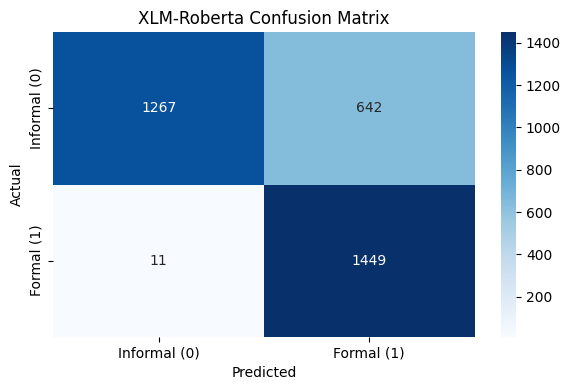

In [9]:
xlmr_confusion_matrix = confusion_matrix(binary_df['formal'].values, xlmr_predicted_labels)
xlmr_accuracy, xlmr_precision, xlmr_recall, xlmr_f1 = calculate_metrics(binary_df['formal'].values, xlmr_predicted_labels)

display_metrics("XLM-Roberta", xlmr_confusion_matrix, xlmr_accuracy, xlmr_precision, xlmr_recall, xlmr_f1)

### DistilBERT Model


DistilBERT Performance Metrics:
╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ Accuracy  │  0.8154 │
├───────────┼─────────┤
│ Precision │  0.7048 │
├───────────┼─────────┤
│ Recall    │  0.9877 │
├───────────┼─────────┤
│ F1 Score  │  0.8226 │
╘═══════════╧═════════╛


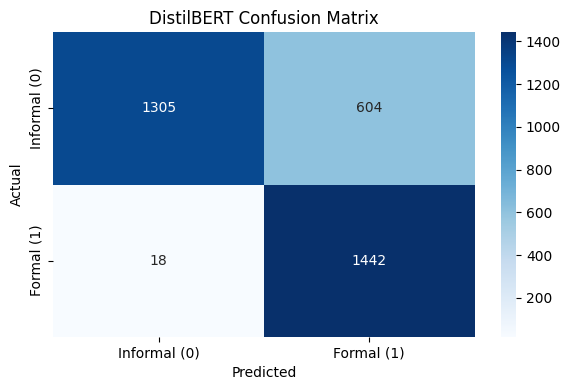

In [10]:
distilbert_confusion_matrix = confusion_matrix(binary_df['formal'].values, distilbert_predicted_labels)
distilbert_accuracy, distilbert_precision, distilbert_recall, distilbert_f1 = calculate_metrics(binary_df['formal'].values, distilbert_predicted_labels)

display_metrics("DistilBERT", distilbert_confusion_matrix, distilbert_accuracy, distilbert_precision, distilbert_recall, distilbert_f1)

### DeBERTa Large Model


DeBERTa Large Performance Metrics:
╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ Accuracy  │  0.8652 │
├───────────┼─────────┤
│ Precision │  0.769  │
├───────────┼─────────┤
│ Recall    │  0.9849 │
├───────────┼─────────┤
│ F1 Score  │  0.8637 │
╘═══════════╧═════════╛


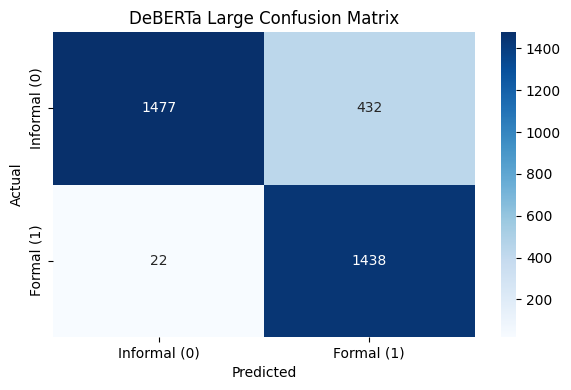

In [11]:
deberta_large_confusion_matrix = confusion_matrix(binary_df['formal'].values, deberta_large_predicted_labels)
deberta_large_accuracy, deberta_large_precision, deberta_large_recall, deberta_large_f1 = calculate_metrics(binary_df['formal'].values, deberta_large_predicted_labels)

display_metrics("DeBERTa Large", deberta_large_confusion_matrix, deberta_large_accuracy, deberta_large_precision, deberta_large_recall, deberta_large_f1)
